## CIFAR10 Image Classification Production Deployment

![cifar10](demo.png)

We show an image classifier (CIFAR10) with associated outlier and drift detectors using a Pipeline.

 * The model is a tensorflow [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) image classfier 
 * The outlier detector is created from the [CIFAR10 VAE Outlier example](https://docs.seldon.io/projects/alibi-detect/en/stable/examples/od_vae_cifar10.html).
 * The drift detector is created from the [CIFAR10 KS Drift example](https://docs.seldon.io/projects/alibi-detect/en/stable/examples/cd_ks_cifar10.html)
 
### Model Training (optional for notebook)

To run local training run the [training notebook](train.ipynb).

In [1]:
import requests
import json
from typing import Dict, List
import numpy as np
import os
import tensorflow as tf
from alibi_detect.utils.perturbation import apply_mask
from alibi_detect.datasets import fetch_cifar10c
import matplotlib.pyplot as plt
tf.keras.backend.clear_session()

2022-10-06 16:32:05.092402: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-06 16:32:05.092425: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
train, test = tf.keras.datasets.cifar10.load_data()
X_train, y_train = train
X_test, y_test = test

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)


(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


In [3]:
outliers = []
for idx in range(0,X_train.shape[0]):
    X_mask, mask = apply_mask(X_train[idx].reshape(1, 32, 32, 3),
                                  mask_size=(12,12),
                                  n_masks=1,
                                  channels=[0,1,2],
                                  mask_type='normal',
                                  noise_distr=(0,1),
                                  clip_rng=(0,1))
    outliers.append(X_mask)
X_outliers = np.vstack(outliers)
X_outliers.shape

(50000, 32, 32, 3)

In [4]:
corruption = ['gaussian_noise']
X_corr, y_corr = fetch_cifar10c(corruption=corruption, severity=5, return_X_y=True)
X_corr = X_corr.astype('float32') / 255

In [5]:
reqJson = json.loads('{"inputs":[{"name":"input_1","data":[],"datatype":"FP32","shape":[]}]}')
url = "http://0.0.0.0:9000/v2/models/model/infer"

In [6]:
def infer(resourceName: str, batchSz: int, requestType: str):
    if requestType == "outlier":
        rows = X_outliers[0:0+batchSz]
    elif requestType == "drift":
        rows = X_corr[0:0+batchSz]
    else:
        rows = X_train[0:0+batchSz]
    for i in range(batchSz):
        show(rows[i])
    reqJson["inputs"][0]["data"] = rows.flatten().tolist()
    reqJson["inputs"][0]["shape"] = [batchSz, 32, 32, 3]
    headers = {"Content-Type": "application/json", "seldon-model":resourceName}
    response_raw = requests.post(url, json=reqJson, headers=headers)
    print(response_raw)
    print(response_raw.json())
    

def show(X):
    plt.imshow(X.reshape(32, 32, 3))
    plt.axis("off")
    plt.show()


### Pipeline

In [7]:
!cat ../../models/cifar10.yaml
!echo "---"
!cat ../../models/cifar10-outlier-detect.yaml
!echo "---"
!cat ../../models/cifar10-drift-detect.yaml

apiVersion: mlops.seldon.io/v1alpha1
kind: Model
metadata:
  name: cifar10
spec:
  storageUri: "gs://seldon-models/triton/tf_cifar10"
  requirements:
  - tensorflow
---
apiVersion: mlops.seldon.io/v1alpha1
kind: Model
metadata:
  name: cifar10-outlier
spec:
  storageUri: "gs://seldon-models/scv2/examples/cifar10/outlier-detector"
  requirements:
    - mlserver
    - alibi-detect
---
apiVersion: mlops.seldon.io/v1alpha1
kind: Model
metadata:
  name: cifar10-drift
spec:
  storageUri: "gs://seldon-models/scv2/examples/cifar10/drift-detector"
  requirements:
    - mlserver
    - alibi-detect


In [8]:
!seldon model load -f ../../models/cifar10.yaml
!seldon model load -f ../../models/cifar10-outlier-detect.yaml
!seldon model load -f ../../models/cifar10-drift-detect.yaml

{}
{}
{}


In [9]:
!seldon model status cifar10 -w ModelAvailable | jq .
!seldon model status cifar10-outlier -w ModelAvailable | jq .
!seldon model status cifar10-drift -w ModelAvailable | jq .

{}
{}
{}


In [10]:
!cat ../../pipelines/cifar10.yaml

apiVersion: mlops.seldon.io/v1alpha1
kind: Pipeline
metadata:
  name: cifar10-production
spec:
  steps:
    - name: cifar10
    - name: cifar10-outlier
    - name: cifar10-drift
      batch:
        size: 20
  output:
    steps:
    - cifar10
    - cifar10-outlier.outputs.is_outlier


In [11]:
!seldon pipeline load -f ../../pipelines/cifar10.yaml

{}


In [12]:
!seldon pipeline status cifar10-production -w PipelineReady| jq -M .

{
  "pipelineName": "cifar10-production",
  "versions": [
    {
      "pipeline": {
        "name": "cifar10-production",
        "uid": "ccvfa5t4nntrbfkuk5hg",
        "version": 2,
        "steps": [
          {
            "name": "cifar10"
          },
          {
            "name": "cifar10-drift",
            "batch": {
              "size": 20
            }
          },
          {
            "name": "cifar10-outlier"
          }
        ],
        "output": {
          "steps": [
            "cifar10.outputs",
            "cifar10-outlier.outputs.is_outlier"
          ]
        },
        "kubernetesMeta": {}
      },
      "state": {
        "pipelineVersion": 2,
        "status": "PipelineReady",
        "reason": "created pipeline",
        "lastChangeTimestamp": "2022-10-06T15:32:39.926431438Z"
      }
    }
  ]
}


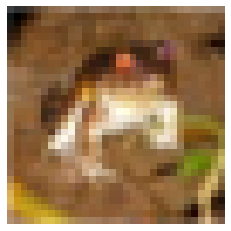

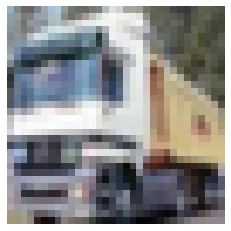

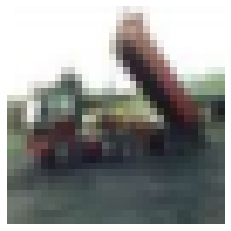

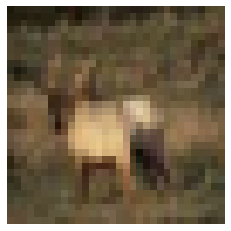

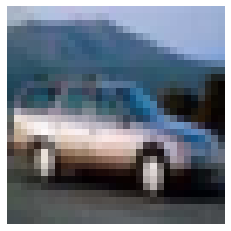

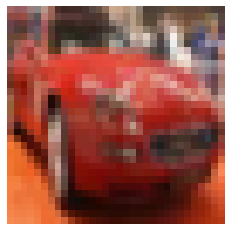

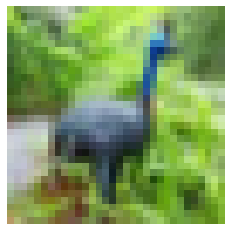

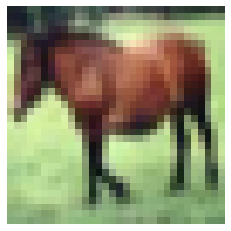

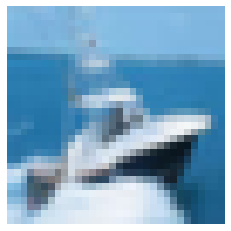

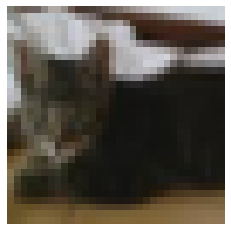

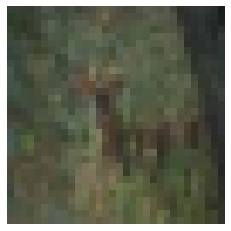

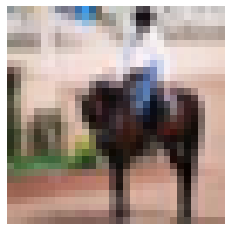

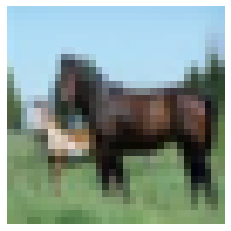

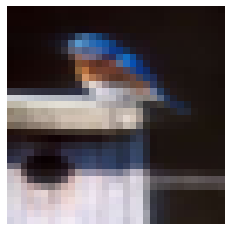

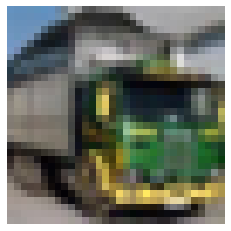

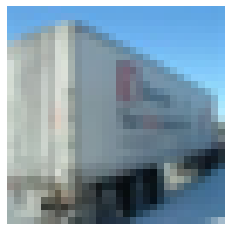

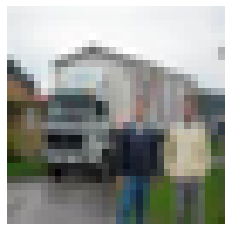

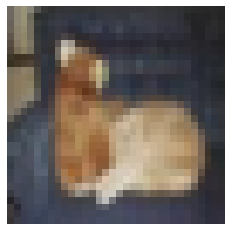

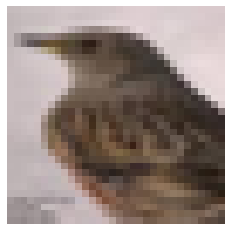

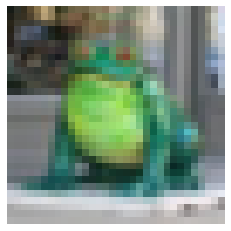

<Response [200]>
{'model_name': '', 'outputs': [{'data': [1.4500082e-08, 1.2525715e-09, 1.6298364e-07, 0.11529311, 1.7431313e-07, 6.1856485e-06, 0.88470024, 6.073899e-09, 7.437885e-08, 4.73172e-09, 1.2644817e-06, 4.88144e-09, 1.5153264e-09, 8.4905425e-09, 5.513056e-10, 1.1617127e-09, 5.7728744e-10, 2.8839528e-07, 0.0006148928, 0.99938357, 0.88874614, 2.5331808e-06, 0.00012967634, 0.105315745, 2.4284038e-05, 6.3332695e-06, 0.0016261397, 1.1307816e-05, 0.0013286571, 0.002809183, 2.0993398e-06, 3.680442e-08, 0.0013269989, 2.1766682e-05, 0.99841356, 0.00015300752, 6.947217e-06, 1.3277109e-05, 6.18605e-05, 3.4072772e-07, 1.1205097e-05, 0.99997175, 1.9948209e-07, 6.9880706e-08, 3.338707e-08, 5.260304e-08, 3.0352362e-07, 4.37389e-08, 5.3243895e-07, 1.5870555e-05, 0.00065251003, 0.013322163, 1.4803151e-06, 0.97663224, 4.9847342e-05, 0.00058076304, 0.008405762, 5.223446e-06, 0.00023390213, 0.0001160483, 1.6682318e-06, 5.7737415e-10, 0.9975605, 6.4556276e-05, 0.0023719606, 1.03926354e-07, 9.7479

In [13]:
infer("cifar10-production.pipeline",20, "normal")

In [14]:
!seldon pipeline inspect cifar10-production.cifar10-drift.outputs.is_drift

seldon.default.model.cifar10-drift.outputs	ccvfa7pi3pn0vadt0di0	{"name":"is_drift", "datatype":"INT64", "shape":["1"], "contents":{"int64Contents":["0"]}}


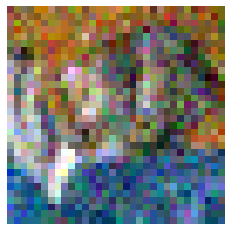

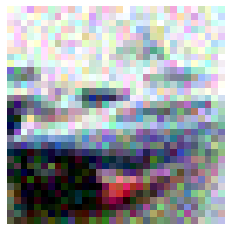

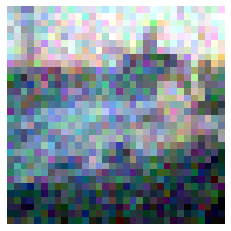

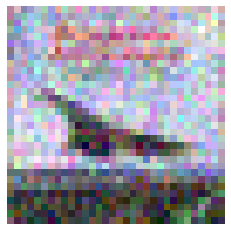

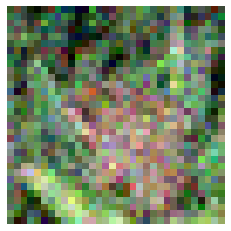

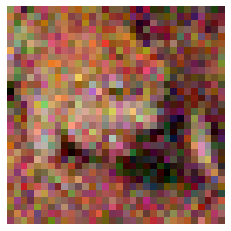

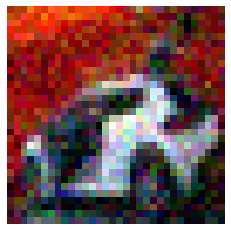

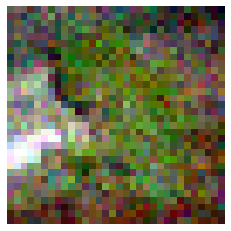

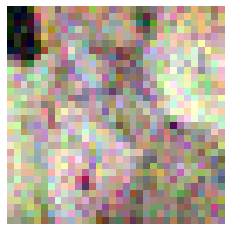

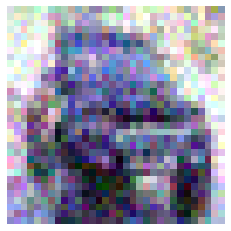

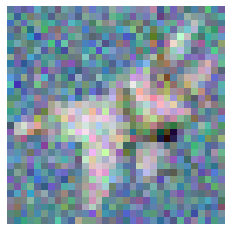

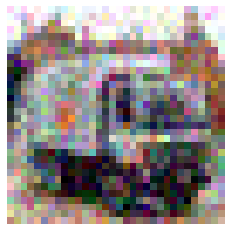

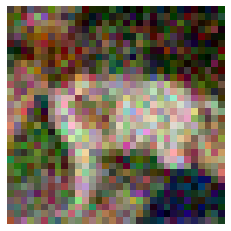

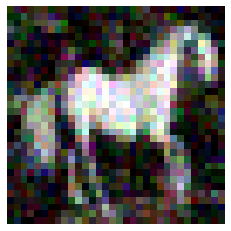

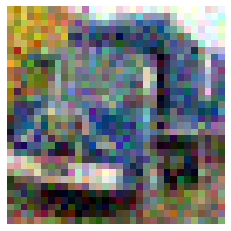

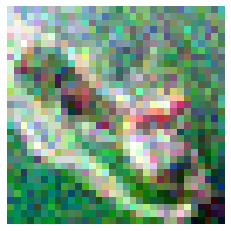

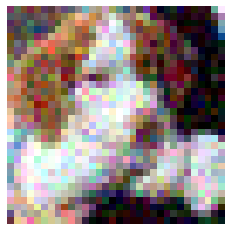

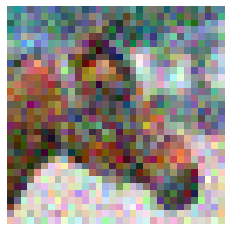

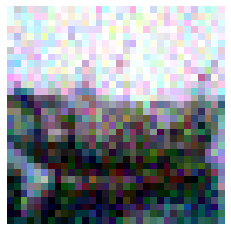

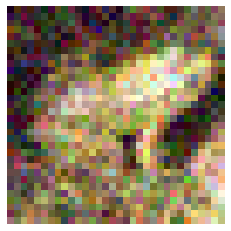

<Response [200]>
{'model_name': '', 'outputs': [{'data': [1.6211126e-09, 4.0089623e-10, 0.00045838102, 0.93237555, 4.15139e-07, 8.396934e-06, 0.067157224, 9.056127e-10, 2.3455957e-09, 1.2709092e-10, 0.0013329195, 8.31132e-06, 0.92835444, 0.0049285158, 0.0068845307, 0.0003594609, 0.00044588748, 1.1627344e-05, 0.057670027, 4.2462384e-06, 6.1743613e-06, 4.222963e-06, 0.009117634, 0.6239805, 3.544544e-05, 0.00017580659, 1.2707604e-05, 8.816747e-07, 0.36666605, 6.166467e-07, 4.3034703e-05, 1.115552e-06, 0.9716082, 0.003606853, 0.0002933709, 0.000113066366, 0.00059629255, 1.5656527e-05, 0.023721391, 9.69018e-07, 1.3783852e-06, 9.712964e-08, 0.11059789, 0.88907194, 4.8204773e-05, 3.7169844e-05, 0.00024244905, 2.9864788e-07, 4.902785e-07, 1.5026147e-08, 5.976571e-07, 1.7624993e-07, 0.27393368, 0.72576165, 6.0214476e-05, 0.00011405839, 0.00012225457, 1.455988e-06, 5.937307e-06, 3.244706e-08, 2.6818164e-08, 1.9999252e-08, 0.00013637826, 0.9135115, 2.4218687e-07, 3.2018372e-07, 0.08635152, 4.2980

In [15]:
infer("cifar10-production.pipeline",20, "drift")

In [16]:
!seldon pipeline inspect cifar10-production.cifar10-drift.outputs.is_drift

seldon.default.model.cifar10-drift.outputs	ccvfac1i3pn0vadt0dig	{"name":"is_drift", "datatype":"INT64", "shape":["1"], "contents":{"int64Contents":["1"]}}


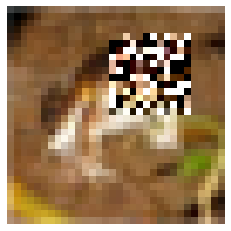

<Response [200]>
{'model_name': '', 'outputs': [{'data': [0.0007882897, 0.00011240715, 8.967017e-05, 0.015603337, 3.67151e-05, 0.008521079, 0.97396415, 6.24793e-06, 0.0008641859, 1.3902612e-05], 'name': 'fc10', 'shape': [1, 10], 'datatype': 'FP32'}, {'data': [1], 'name': 'is_outlier', 'shape': [1, 1], 'datatype': 'INT64'}]}


In [17]:
infer("cifar10-production.pipeline",1, "outlier")

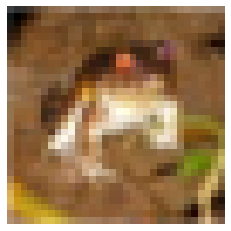

<Response [200]>
{'model_name': '', 'outputs': [{'data': [1.4500107e-08, 1.2525738e-09, 1.6298331e-07, 0.115293205, 1.7431327e-07, 6.185636e-06, 0.8847001, 6.0738867e-09, 7.437898e-08, 4.7317195e-09], 'name': 'fc10', 'shape': [1, 10], 'datatype': 'FP32'}, {'data': [0], 'name': 'is_outlier', 'shape': [1, 1], 'datatype': 'INT64'}]}


In [18]:
infer("cifar10-production.pipeline",1, "ok")

Use the seldon CLI to look at the outputs from the CIFAR10 model. It will decide the Triton binary outputs for us.

In [19]:
!seldon pipeline inspect cifar10-production.cifar10.outputs

seldon.default.model.cifar10.outputs	ccvfafpi3pn0vadt0djg	{"modelName":"cifar10_1", "modelVersion":"1", "outputs":[{"name":"fc10", "datatype":"FP32", "shape":["1", "10"], "contents":{"fp32Contents":[1.4500107e-8, 1.2525738e-9, 1.6298331e-7, 0.115293205, 1.7431327e-7, 0.000006185636, 0.8847001, 6.0738867e-9, 7.437898e-8, 4.7317195e-9]}}]}


In [20]:
!seldon pipeline unload cifar10-production

{}


In [21]:
!seldon model unload cifar10
!seldon model unload cifar10-outlier
!seldon model unload cifar10-drift

{}
{}
{}
